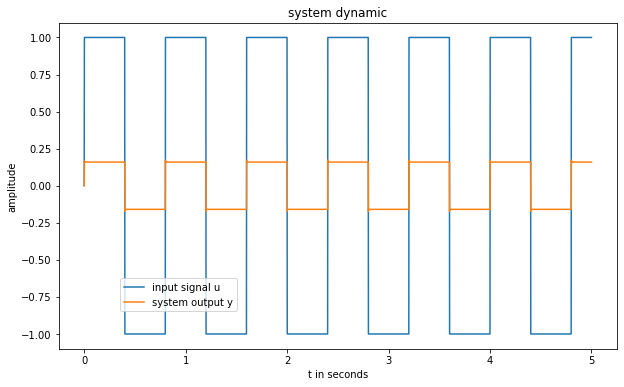

In [16]:
import numpy as np
# system
def systemOutput(ytminus1,utminus1):
    return (-0.25*ytminus1+utminus1)/(6+ytminus1**2)

#Input signal
sfreq=1e3
tmin = 0
tmax = 5
t = np.linspace(tmin,tmax,int((tmax-tmin)*sfreq))
u = np.sign(np.sin(2.5*np.pi*t))
y = np.zeros(len(t))
for t_i in range(len(t)-1):
    y[t_i+1] = systemOutput(y[t_i],u[t_i])
#Output


#Visualization
from matplotlib import pyplot as plt
fig = plt.figure(figsize = [10,6])
ax1 = fig.add_subplot(111)
ax1.plot(t,u,label='input signal u')
ax1.plot(t,y,label='system output y')
ax1.set_title('system dynamic')
ax1.set_xlabel('t in seconds')
ax1.set_ylabel('amplitude')
ax1.legend(loc='lower left', bbox_to_anchor=(0.1,0.1))

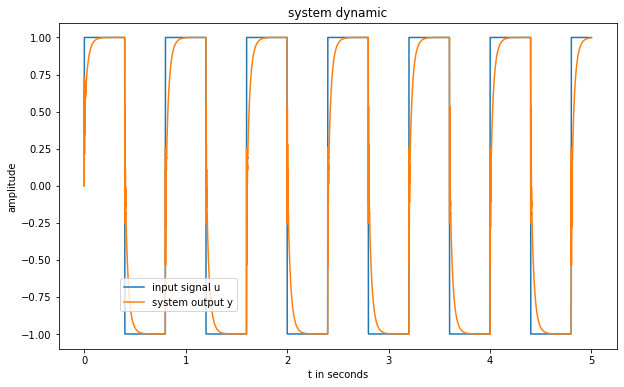

In [22]:
# closed loop behavior with PID
import numpy as np
from IPython.core.debugger import set_trace
def systemOutput(ytminus1,utminus1):
    return (-0.25*ytminus1+utminus1)/(6+ytminus1**2)
Kc = 4
tauI = 0.01
tauD = 0
# command signal
sfreq=1e3
tmin = 0
tmax = 5
t = np.linspace(tmin,tmax,int((tmax-tmin)*sfreq))
u = np.sign(np.sin(2.5*np.pi*t))

y = np.zeros(len(t))
e = np.zeros(len(t))
de = np.zeros(len(t))
ie = np.zeros(len(t)) # integral of error
PID_op = np.zeros(len(t)) #PID output
for t_i in range(len(t)-1):
    e[t_i+1] = u[t_i] - y[t_i]
    de[t_i+1] = (e[t_i+1] - e[t_i])*sfreq
    ie[t_i+1] = ie[t_i] + e[t_i+1] / sfreq
    PID_op[t_i+1] = Kc*e[t_i+1] + Kc/tauI*ie[t_i+1] - Kc * tauD * de[t_i+1]
    y[t_i+1] = systemOutput(y[t_i],PID_op[t_i+1])
#     set_trace()
#Visualization
from matplotlib import pyplot as plt
fig = plt.figure(figsize = [10,6])
ax1 = fig.add_subplot(111)
ax1.plot(t,u,label='input signal u')
ax1.plot(t,y,label='system output y')
ax1.set_title('system dynamic')
ax1.set_xlabel('t in seconds')
ax1.set_ylabel('amplitude')
ax1.legend(loc='lower left', bbox_to_anchor=(0.1,0.1))

# Next stage - RBF training

In [1]:
# RBF network

import numpy as np


def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


def kmeans(X, k, max_iters):
    ''' find k centroid based on X, as an unsupervised learning to get the central vector of a RBF-NN'''
    centroids = X[np.random.choice(range(len(X)), k, replace=False)] # initialize k centroids
    converged = False
    
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))] # create k list

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x) # distribute x of X into one of centroid, dim = len(X)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0)) # update centroids based on xs that belong to the current centroid 

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids)) # To test whether this process is converged

#         print('K-MEANS: ', pattern)

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list] # for each cluster, find the std of its members

class RBF:

    def __init__(self, X, y, tX, ty, num_of_classes,
                 k, std_from_clusters=True):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty

        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def rbf(self, x, c, s): # s is the standard error, rbf return the proba of the membership degree of x to a given centroid c
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)
    

    def fit(self):

        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=500)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list) # dim = len(X)

        #self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)
        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.y
        # predicting tX=testX
        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.ty
#         print(diff)
#         print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))
        return self.pred_ty

In [35]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, RepeatVector, TimeDistributed
import keras
def rbf(x, c, s): # s is the standard error, rbf return the proba of the membership degree of x to a given centroid c
    distance = get_distance(x, c)
    return 1 / np.exp(-distance / s ** 2)

def rbf_list(X, centroids, std_list):
    RBF_list = []
    for x in X:
        RBF_list.append([rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
    return np.array(RBF_list)
def RBF_trans(X,k,max_iters):
    centroids, std_list = kmeans(X, k, max_iters)
    dMax = np.max([get_distance(c1, c2) for c1 in centroids for c2 in centroids])
    std_list = np.repeat(dMax / np.sqrt(2 * k), k)    
    RBF_X = rbf_list(X, centroids, std_list) # dim = len(X)
    return RBF_X,centroids,std_list

# data generation 
mean = 0
std = 1 
num_samples = 2000
u = np.random.normal(mean, std, size=num_samples)
def systemOutput(ytminus1,utminus1):
    return (-0.25*ytminus1+utminus1)/(6+ytminus1**2)
y = np.zeros(len(u))
for t_i in range(len(u)-1):
    y[t_i+1] = systemOutput(y[t_i],u[t_i])
train_x =np.vstack((u[:len(y)-1],y[:len(y)-1])).T  
train_x_RBF,centroids,std_list = RBF_trans(train_x,6,500)

def generatemodel(numparam):
    model = Sequential()
    model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam')
    return model

mod = generatemodel(6)
mod.fit(train_x_RBF, y[1:], batch_size=20, epochs=100, verbose=1, shuffle=True)
yhat = mod.predict(train_x_RBF)

Epoch 1/100
1999/1999 [==============================] - 1s 357us/step - loss: 0.5247
Epoch 2/100
1999/1999 [==============================] - 0s 152us/step - loss: 0.2159
Epoch 3/100
1999/1999 [==============================] - 0s 172us/step - loss: 0.0398
Epoch 4/100
1999/1999 [==============================] - 0s 165us/step - loss: 0.0289
Epoch 5/100
1999/1999 [==============================] - 0s 156us/step - loss: 0.0267
Epoch 6/100
1999/1999 [==============================] - 0s 152us/step - loss: 0.0256
Epoch 7/100
1999/1999 [==============================] - 0s 171us/step - loss: 0.0250
Epoch 8/100
1999/1999 [==============================] - 0s 164us/step - loss: 0.0245
Epoch 9/100
1999/1999 [==============================] - 0s 159us/step - loss: 0.0240
Epoch 10/100
1999/1999 [==============================] - 0s 171us/step - loss: 0.0236
Epoch 11/100
1999/1999 [==============================] - 0s 158us/step - loss: 0.0232
Epoch 12/100
1999/1999 [============================

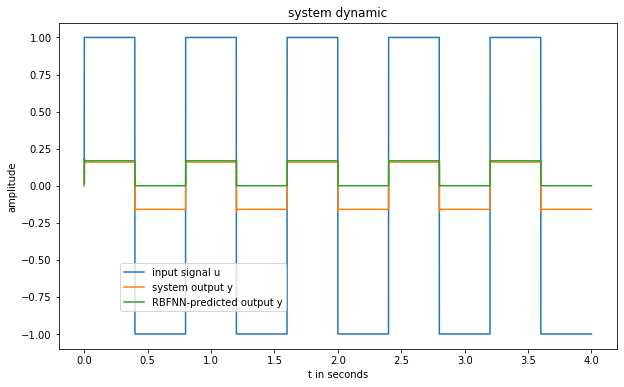

In [36]:
def systemOutput(ytminus1,utminus1):
    return (-0.25*ytminus1+utminus1)/(6+ytminus1**2)

#trainig set generation
sfreq=1e3
tmin = 0
tmax = 4
t = np.linspace(tmin,tmax,int((tmax-tmin)*sfreq))
u = np.sign(np.sin(2.5*np.pi*t))
y = np.zeros(len(t))
for t_i in range(len(t)-1):
    y[t_i+1] = systemOutput(y[t_i],u[t_i])

test_x =np.vstack((u[:len(y)-1],y[:len(y)-1])).T 
test_x_RBF = rbf_list(test_x,centroids,std_list)
yhat = mod.predict(test_x_RBF)
from matplotlib import pyplot as plt
fig = plt.figure(figsize = [10,6])
ax1 = fig.add_subplot(111)
ax1.plot(t,u,label='input signal u')
ax1.plot(t,y,label='system output y')
ax1.plot(t[1:],yhat,label='RBFNN-predicted output y')
ax1.set_title('system dynamic')
ax1.set_xlabel('t in seconds')
ax1.set_ylabel('amplitude')
ax1.legend(loc='lower left', bbox_to_anchor=(0.1,0.1))

# Next step - RBF-NN based PID control
## Note that the centroids,std_list remain fixed during the iteration. This may firstly seemed inappropriate but is logical because the system can be fully identified with enough hidden neuros.

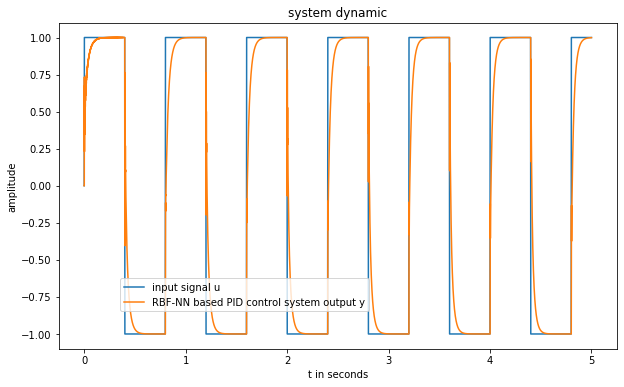

In [75]:
from IPython.core.debugger import set_trace
def systemOutput(ytminus1,utminus1):
    return (-0.25*ytminus1+utminus1)/(6+ytminus1**2)

# command signal
sfreq=1e3
tmin = 0
tmax = 5
k=6 #number of kernel
t = np.linspace(tmin,tmax,int((tmax-tmin)*sfreq))
u = np.sign(np.sin(2.5*np.pi*t))
y = np.zeros(len(t))
e = np.zeros(len(t))
ie = np.zeros(len(t))
PID_op = np.zeros(len(t))
Kc = 4
tauI = 0.01
tauD = 0
Kp=Kc
KI=Kc/tauI
eta = 0.005 #learning rate
W = mod.get_weights()[0]
for t_i in range(len(t)-1):
#     set_trace()
    H = rbf_list(np.array([[u[t_i],y[t_i]]]),centroids,std_list)
    dydu =np.sum(H*W*(centroids[:,0]-np.repeat(np.array([u[t_i]]),repeats=6,axis=0))/std_list)
    e[t_i+1] = u[t_i] - y[t_i]
    ie[t_i+1] = ie[t_i] + e[t_i+1] / sfreq
    PID_op[t_i+1] = Kp*e[t_i+1] + KI*ie[t_i+1] 
    y[t_i+1] = systemOutput(y[t_i],PID_op[t_i+1])
    # update Kp and KI
    Kp = Kp+eta*e[t_i+1]*dydu*(e[t_i+1]-e[t_i])
    KI = KI+eta*e[t_i+1]*dydu*e[t_i+1]
#Visualization  
from matplotlib import pyplot as plt
fig = plt.figure(figsize = [10,6])
ax1 = fig.add_subplot(111)
ax1.plot(t,u,label='input signal u')
ax1.plot(t,y,label='RBF-NN based PID control system output y')
ax1.set_title('system dynamic')
ax1.set_xlabel('t in seconds')
ax1.set_ylabel('amplitude')
ax1.legend(loc='lower left', bbox_to_anchor=(0.1,0.1))

# Superpose the effect of PID and RBF°NN PID

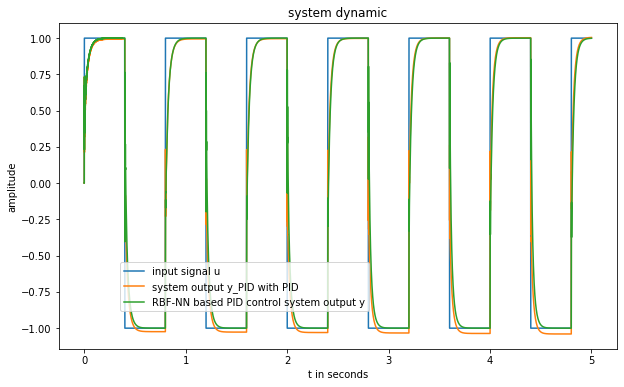

In [78]:
# closed loop behavior with PID
import numpy as np
from IPython.core.debugger import set_trace
def systemOutput(ytminus1,utminus1):
    return (-0.25*ytminus1+utminus1)/(6+ytminus1**2)
Kc = 4
tauI = 0.01
tauD = 0
# command signal
sfreq=1e3
tmin = 0
tmax = 5
t = np.linspace(tmin,tmax,int((tmax-tmin)*sfreq))
u = np.sign(np.sin(2.5*np.pi*t))

y_raw = np.zeros(len(t))
e = np.zeros(len(t))
de = np.zeros(len(t))
ie = np.zeros(len(t)) # integral of error
PID_op = np.zeros(len(t)) #PID output
for t_i in range(len(t)-1):
    e[t_i+1] = u[t_i] - y[t_i]
    de[t_i+1] = (e[t_i+1] - e[t_i])*sfreq
    ie[t_i+1] = ie[t_i] + e[t_i+1] / sfreq
    PID_op[t_i+1] = Kc*e[t_i+1] + Kc/tauI*ie[t_i+1] - Kc * tauD * de[t_i+1]
    y_raw[t_i+1] = systemOutput(y[t_i],PID_op[t_i+1])
#     set_trace()
#Visualization
from matplotlib import pyplot as plt
fig = plt.figure(figsize = [10,6])
ax1 = fig.add_subplot(111)
ax1.plot(t,u,label='input signal u')
ax1.plot(t,y_raw,label='system output y_PID with PID')
ax1.plot(t,y,label='RBF-NN based PID control system output y')
ax1.set_title('system dynamic')
ax1.set_xlabel('t in seconds')
ax1.set_ylabel('amplitude')
ax1.legend(loc='lower left', bbox_to_anchor=(0.1,0.1))

In [60]:
np.array([1,2,1,2,1,2])*(centroids[:,0]-np.repeat(np.array([1]),repeats=6,axis=0))/std_list

array([-6.47155849e-01,  3.16670542e-03, -1.24583756e+00, -3.74077326e+00,
        7.83224622e-01, -5.36172747e+00])

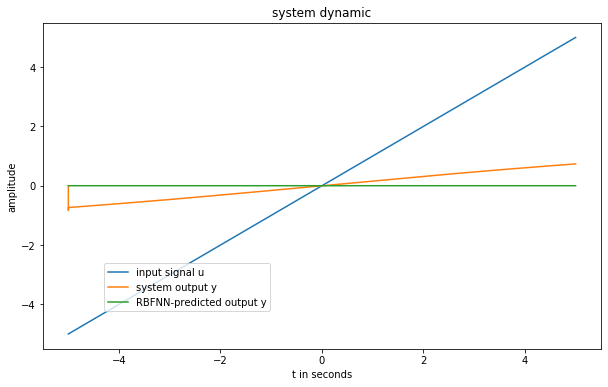

In [9]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = [10,6])
ax1 = fig.add_subplot(111)
ax1.plot(t,u,label='input signal u')
ax1.plot(t,y,label='system output y')
ax1.plot(t[1:],yhat,label='RBFNN-predicted output y')
ax1.set_title('system dynamic')
ax1.set_xlabel('t in seconds')
ax1.set_ylabel('amplitude')
ax1.legend(loc='lower left', bbox_to_anchor=(0.1,0.1))
